#### LeViT: a Vision Transformer in ConvNet's Clothing for Faster Inference
- 속도와 정확성 사이 최적화하는 분류 아키텍처
- 해상도가 감소하는 활성 맵(?)에 적용하기 위해 CNN 재검토
- `트랜스포머에 위치 정보를 통합하는 새로운 방법인 Attention Bias 소개`
- 광범위한 APP 시나리오 적용위해 다양한 HW 플랫폼에서 측정
- 80% ImageNet top-1 accuracy, LeViT is 5 times faster than EfficientNet on CPU
  
LeViT-256 architecture  
  
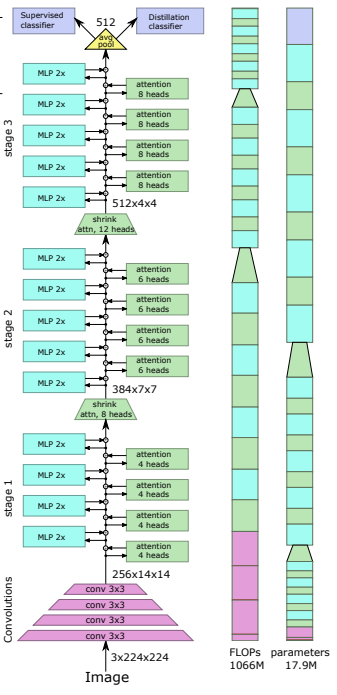

- 오른쪽 두 막대는 FLOP으로 측정된 각 계층의 상대적 자원 소비와 매개변수 수

<모델링 원리>
- LeViT는 ViT [2] 아키텍처와 DeiT [3] 훈련 방법을 기반으로 구축
- 분류 임베딩 역할을 무시한 ViT는 활성화 맵을 처리하는 레이어 스택(?) 이다.

<모델 구성 요소>
- Patch Embedding: 사전 분석에서 트랜스포머 입력 부분 작은 ConvNet은 정확도 향상을 가져온다.
  - ...
- No Classification Token: BCHW 포맷을 사용하기 위해 분류 토큰을 제거하였다.
  - 분류 토큰을 avg pooling으로 교체하였다.
  - 훈련 중 Distillation을 위해 분류 및 증류 작업을 위한 별도 헤드 훈련하였다.
  - 테스트 시 두 헤드 출력을 평균하였다.
  - 실제로 LeVIT는 BNC, BCHW 텐서 형식 중 더 효율적인 형식 사용하여 구현할 수 있다.

- ...
- 포지셔닝 임베딩 대신 Attention Bias
  - 포지셔닝 임베딩은 트랜스 포머의 입력전에 토큰 임베딩에 추가되는 위치 종속 학습 가능한 매개변수 벡터이다.
  - 사용하지 않는다면, 트랜스 포머 출력은 입력 토큰 순열에 독립적이다.
  - 


In [ ]:
import torch
import itertools
import utils

from timm.models.vision_transformer import trunc_normal_
from timm.models.registry import register_model

specification = {
    'LeViT_128S': {
        'C': '128_256_384', 'D': 16, 'N': '4_6_8', 'X': '2_3_4', 'drop_path': 0,
        'weights': 'https://dl.fbaipublicfiles.com/LeViT/LeViT-128S-96703c44.pth'},
    'LeViT_128': {
        'C': '128_256_384', 'D': 16, 'N': '4_8_12', 'X': '4_4_4', 'drop_path': 0,
        'weights': 'https://dl.fbaipublicfiles.com/LeViT/LeViT-128-b88c2750.pth'},
    'LeViT_192': {
        'C': '192_288_384', 'D': 32, 'N': '3_5_6', 'X': '4_4_4', 'drop_path': 0,
        'weights': 'https://dl.fbaipublicfiles.com/LeViT/LeViT-192-92712e41.pth'},
    'LeViT_256': {
        'C': '256_384_512', 'D': 32, 'N': '4_6_8', 'X': '4_4_4', 'drop_path': 0,
        'weights': 'https://dl.fbaipublicfiles.com/LeViT/LeViT-256-13b5763e.pth'},
    'LeViT_384': {
        'C': '384_512_768', 'D': 32, 'N': '6_9_12', 'X': '4_4_4', 'drop_path': 0.1,
        'weights': 'https://dl.fbaipublicfiles.com/LeViT/LeViT-384-9bdaf2e2.pth'},
}

__all__ = [specification.keys()]

class LeViT(torch.nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """

    def __init__(self, img_size=224,
                 patch_size=16,
                 in_chans=3,
                 num_classes=1000,
                 embed_dim=[192],
                 key_dim=[64],
                 depth=[12],
                 num_heads=[3],
                 attn_ratio=[2],
                 mlp_ratio=[2],
                 hybrid_backbone=None,
                 down_ops=[],
                 attention_activation=torch.nn.Hardswish,
                 mlp_activation=torch.nn.Hardswish,
                 distillation=True,
                 drop_path=0):
        super().__init__()
        global FLOPS_COUNTER
        
        self.num_classes = num_classes
        self.num_features = embed_dim[-1]
        self.embed_dim = embed_dim
        self.distillation = distillation

        self.patch_embed = hybrid_backbone

        self.blocks = []
        down_ops.append([''])
        resolution = img_size // patch_size
        for i, (ed, kd, dpth, nh, ar, mr, do) in enumerate(
                zip(embed_dim, key_dim, depth, num_heads, attn_ratio, mlp_ratio, down_ops)):
            for _ in range(depth):
                self.blocks.append(
                    Residual(
                        Attention(
                        ed, kd, nh,
                        attn_ratio=ar,
                        activation=attention_activation,
                        resolution=resolution,
                        ), 
                        drop_path)
                    )

                if mr > 0:
                    h = int(ed * mr)
                    self.blocks.append(
                        Residual(torch.nn.Sequential(
                            Linear_BN(ed, h, resolution=resolution),
                            mlp_activation(),
                            Linear_BN(h, ed, bn_weight_init=0, resolution=resolution),
                        ), drop_path))
            
            if do[0] == 'Subsample':
                #('Subsample',key_dim, num_heads, attn_ratio, mlp_ratio, stride)
                resolution_ = (resolution - 1) // do[5] + 1
                self.blocks.append(
                    AttentionSubsample(
                        *embed_dim[i:i + 2], key_dim=do[1], num_heads=do[2],
                        attn_ratio=do[3],
                        activation=attention_activation,
                        stride=do[5],
                        resolution=resolution,
                        resolution_=resolution_)
                )
                resolution = resolution_

                if do[4] > 0:  # mlp_ratio
                    h = int(embed_dim[i + 1] * do[4])
                    self.blocks.append(
                        Residual(
                            torch.nn.Sequential(
                            Linear_BN(embed_dim[i + 1], h, resolution=resolution),
                            mlp_activation(),
                            Linear_BN(h, embed_dim[i + 1], bn_weight_init=0, resolution=resolution),
                            ), 
                            drop_path)
                    )
        self.blocks = torch.nn.Sequential(*self.blocks)

        # Classifier head
        self.head = BN_Linear(
            embed_dim[-1], num_classes) if num_classes > 0 else torch.nn.Identity()

        if distillation:
            self.head_dist = BN_Linear(
                embed_dim[-1], num_classes) if num_classes > 0 else torch.nn.Identity()

        self.FLOPS = FLOPS_COUNTER
        FLOPS_COUNTER = 0

    @torch.jit.ignore
    def no_weight_decay(self):
        return {x for x in self.state_dict().keys() if 'attention_biases' in x}

    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        x = self.blocks(x)
        x = x.mean(1)
        if self.distillation:
            x = self.head(x), self.head_dist(x)
            if not self.training:
                x = (x[0] + x[1]) / 2
        else:
            x = self.head(x)
        return x


In [ ]:
class Conv2d_BN(torch.nn.Sequential):
    def __init__(self, a, b, ks=1, stride=1, pad=0, dilation=1,
                 groups=1, bn_weight_init=1):
        super().__init__()
        self.add_module('c', torch.nn.Conv2d(
            a, b, ks, stride, pad, dilation, groups, bias=False))
        bn = torch.nn.BatchNorm2d(b)
        torch.nn.init.constant_(bn.weight, bn_weight_init)
        torch.nn.init.constant_(bn.bias, 0)
        self.add_module('bn', bn)

    @torch.no_grad()
    def fuse(self):
        c, bn = self._modules.values()
        w = bn.weight / (bn.running_var + bn.eps)**0.5
        w = c.weight * w[:, None, None, None]
        b = bn.bias - bn.running_mean * bn.weight / (bn.running_var + bn.eps)**0.5
        m = torch.nn.Conv2d(
            w.size(1) * self.c.groups, 
            w.size(0),
            w.shape[2:],
            stride=self.c.stride, padding=self.c.padding, dilation=self.c.dilation, groups=self.c.groups)
        m.weight.data.copy_(w)
        m.bias.data.copy_(b)
        return m

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self, dim, 
                key_dim, num_heads=8,
                 attn_ratio=4,
                 activation=None,
                 resolution=14):
        super().__init__()
        # (h, w)
        assert isinstance(resolution, tuple) and len(resolution) == 2
        self.num_heads = num_heads
        self.scale = key_dim ** -0.5
        self.key_dim = key_dim
        self.nh_kd = nh_kd = key_dim * num_heads
        self.d = int(attn_ratio * key_dim)
        self.dh = int(attn_ratio * key_dim) * num_heads
        self.attn_ratio = attn_ratio
        h = self.dh + nh_kd * 2

        self.norm = nn.LayerNorm(dim)
        self.qkv = nn.Linear(dim, h)
        self.proj = nn.Linear(self.dh, dim)

        points = list(itertools.product(
            range(resolution[0]), range(resolution[1])
        ))
        N = len(points)

        attention_offsets = {}
        idxs = []

        for p1 in points:
            for p2 in points:
                offset = (abs(p1[0] - p2[0]), abs(p1[1] - p2[1]))
                if offset not in attention_offsets:
                    attention_offsets[offset] = len(attention_offsets)
                idxs.append(attention_offsets[offset])

        self.attention_biases = torch.nn.Parameter(
            torch.zeros(num_heads, len(attention_offsets)))

        self.register_buffer('attention_bias_idxs',
                            torch.LongTensor(idxs).view(N, N),
                            persistent=False)

    @torch.no_grad()
    def train(self, mode=True):
        super().train(mode)
        if mode and hasattr(self, 'ab'):
            del self.ab
        else:
            self.register_buffer('ab',
                                 self.attention_biases[:, self.attention_bias_idxs],
                                 persistent=False)

    def forward(self, x):
        B, N, _ = x.shape

        # Normalization
        x = self.norm(x)

        qkv = self.qkv(x)

        #(B, N, num_heads, d)
        q, k, v = qkv.view(B, N, self.num_heads, -1).split([self.key_dim, self.key_dim, self.d], dim=3)
        # (B, num_heads, N, d)
        q = q.permute(0, 2, 1, 3)
        k = k.permute(0, 2, 1, 3)
        v = v.permute(0, 2, 1, 3)

        attn = (
            (q @ k.transpose(-2, -1)) * self.scale
            +
            (self.attention_biases[:, self.attention_bias_idxs]
            if self.training else self.ab)
        )
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, self.dh)
        x = self.proj(x)
        return x

https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/levit.py

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, fmap_size, heads = 8, dim_key = 32, dim_value = 64, dropout = 0., dim_out = None, downsample = False):
        super().__init__()
        inner_dim_key = dim_key *  heads # d_model ?
        inner_dim_value = dim_value *  heads
        dim_out = default(dim_out, dim)

        self.heads = heads
        self.scale = dim_key ** -0.5

        self.to_q = nn.Sequential(
            nn.Conv2d(dim, inner_dim_key, 1, 
            stride = (2 if downsample else 1), bias = False),
            nn.BatchNorm2d(inner_dim_key))
        self.to_k = nn.Sequential(nn.Conv2d(dim, inner_dim_key, 1, bias = False), nn.BatchNorm2d(inner_dim_key))
        self.to_v = nn.Sequential(nn.Conv2d(dim, inner_dim_value, 1, bias = False), nn.BatchNorm2d(inner_dim_value))

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        out_batch_norm = nn.BatchNorm2d(dim_out)
        nn.init.zeros_(out_batch_norm.weight)

        self.to_out = nn.Sequential(
            nn.GELU(),
            nn.Conv2d(inner_dim_value, dim_out, 1),
            out_batch_norm,
            nn.Dropout(dropout)
        )